In [1]:
# Local paths
dir_pfx = './'
data_dir = dir_pfx + '../../data/Vehicules1024/'
# Add the local_modules directory to the set of paths
# Python uses to look for imports.
import sys
sys.path.append(dir_pfx)

In [2]:
#!pip3 install -q git+https://www.github.com/keras-team/keras-contrib.git
from keras.utils import Sequence
import numpy as np
import tensorflow as tf

from os import listdir
from os.path import isfile, join
from skimage.transform import downscale_local_mean
import random

import imageio
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [76]:

def normalize(image):
    return (image - 127.5) / 127.5

def un_normalize(image):
    return (image + 1) / 2

def read_VEDAI(subset, PATH_TO_VEHICLES_FOLDER):
    # Takes in the full path to the unzipped "VEHICULES" folder
    # Returns mapping dict, RGB and Infrared images in 
    # (images, x, y, channels) format,
    # saves a txt file with mapping of rgb/infra idx to filename
    # NUM_FILES = 2536
    # MAX_INDEX = 1272
    X_PIXELS = 1024
    Y_PIXELS = 1024
    PATH_TO_VEHICLES_FOLDER = PATH_TO_VEHICLES_FOLDER#[0]

    onlyfiles = [f for f in listdir(PATH_TO_VEHICLES_FOLDER) if isfile(
        join(PATH_TO_VEHICLES_FOLDER, f)) and "png" in f]
    # assert len(onlyfiles) == NUM_FILES, "Not the full VEDAI 1024 Dataset"
    rgb = np.zeros((len(subset), X_PIXELS, Y_PIXELS, 3))
    infra = np.zeros((len(subset), X_PIXELS, Y_PIXELS, 1))
    indices = subset

    print(indices)
    print(rgb.shape)
    index_filename_map = {}
    im_cnt = 0

    for index in indices:
        pair = [file for file in onlyfiles if str(index) in file]
        if pair:
            for file in pair:
                index_filename_map[im_cnt] = file.split('_')[0]
                im = imageio.imread(PATH_TO_VEHICLES_FOLDER + '/' + file)
                if "co" in file:
                    # print('Inserting RGB @ '+ str(im_cnt))
                    rgb[im_cnt, :, :, :] = np.reshape(
                        im, (tuple([1]) + im.shape))
                elif "ir" in file:
                    # print('Inserting Infra @ '+ str(im_cnt))
                    infra[im_cnt, :, :, :] = np.reshape(
                        im, (tuple([1]) + im.shape + tuple([1])))
            im_cnt = im_cnt + 1
        else:
            print("The following image is missing!: " + index)
    # print(index_filename_map)
    f = open(PATH_TO_VEHICLES_FOLDER + "_mapping.txt", "w")
    f.write(str(index_filename_map))
    f.close()
    return rgb, infra


def scan_dataset(PATH_TO_VEHICLES_FOLDER, number_of_imgs):
    # Takes in the full path to the unzipped "VEHICULES" folder
    # Returns a list of all the files
    # and saves a dataset summary text file with list of all file names
    MAX_INDEX = number_of_imgs
    PATH_TO_VEHICLES_FOLDER = PATH_TO_VEHICLES_FOLDER
    indices = [format(n, '08') for n in range(MAX_INDEX)]
    export_files = []

    onlyfiles = [f for f in listdir(PATH_TO_VEHICLES_FOLDER) if isfile(
        join(PATH_TO_VEHICLES_FOLDER, f)) and "png" in f]

    for index in indices:
        pair = [file for file in onlyfiles if str(index) in file]
        if pair:
            for file in pair:
                if "co" in file:
                    export_files.append(file.split('_')[0])
        else:
            print("The following image is missing!: " + index)
    np.savetxt(PATH_TO_VEHICLES_FOLDER + '_summary.txt',
               export_files, delimiter=" ", fmt="%s")

    return export_files


def create_subsets(imgs, output_path, use_validation=True,
                   training_percent=0.7, testing_percent=0.3, SEED=1):
    # Takes a list of image file names and shuffles
    # them before splitting them into required subsets
    # Saves txt files containing the names of the files
    # used in each subset, no return value

    assert training_percent + \
        testing_percent == 1, "Training + testing percents must equal 1."
    random.seed(SEED)
    random.shuffle(imgs)
    print('Using ' + str(len(imgs)) + ' images.')
    print('Saving files to ' + output_path)
    if not use_validation:
        training_imgs = imgs[:int(len(imgs) * training_percent)]
        testing_imgs = imgs[int(len(imgs) * training_percent):]
        np.savetxt(output_path + 'training.txt',
                   training_imgs, delimiter=" ", fmt="%s")
        np.savetxt(output_path + 'testing.txt',
                   testing_imgs, delimiter=" ", fmt="%s")
        return training_imgs, testing_imgs
    else:
        validation_split = 0.3  # use 30% of training dataset for validation
        training_imgs = imgs[int(len(imgs) * validation_split *
                                 training_percent):int(len(imgs) *
                                                       training_percent)]
        validation_imgs = imgs[:int(
            len(imgs) * validation_split * training_percent)]
        testing_imgs = imgs[int(len(imgs) * training_percent):]
        np.savetxt(output_path + 'validation.txt',
                   validation_imgs, delimiter=" ", fmt="%s")
        np.savetxt(output_path + 'training.txt',
                   testing_imgs, delimiter=" ", fmt="%s")
        np.savetxt(output_path + 'testing.txt',
                   testing_imgs, delimiter=" ", fmt="%s")
        return training_imgs, validation_imgs, testing_imgs


def save_VEDAI(rgb, infra):
    # Takes in arrays of rgb and infrared images
    # Saves them to disk, no return value
    np.save("vedai_rgb_all.npy", rgb)
    np.save("vedai_infra_all.npy", infra)


def load_VEDAI():
    # No parameters, expected to run in directory with VEDAI.npy files
    # Returns two arrays with rgb and infrared images respectively
    rgb = np.load("vedai_rgb_all.npy")
    infra = np.load("vedai_infra_all.npy")
    return rgb, infra


def data_explore(data):
    print("Shape of the data is" + str(data.shape))
    print("Dtype of the data is" + str(data.dtype))


def combine_rgb_infra(rgb, infra):
    # Concatenates the two modalities along the channels axis
    four_channel = np.concatenate((rgb, infra), axis=-1)
    return four_channel

  
def overlapping_patches(images, patch_size=(64, 64), padding="VALID"):
    sess = tf.Session()

    num_images, size_x, size_y, channels = images.shape
    ims = tf.convert_to_tensor(images)
    patch_x, patch_y = patch_size
    patches = tf.extract_image_patches(ims, [1, patch_x, patch_y, 1], [
        1, patch_x, patch_y, 1], [1, 1, 1, 1], padding=padding)
    patches_shape = tf.shape(patches)
    with sess.as_default():
        np = tf.reshape(patches, [tf.reduce_prod(patches_shape[0:3]),
                                  patch_x, patch_y, channels]).eval()
        return np  


def non_overlapping_patches(image, patch_size=(64, 64)):
    size_x, size_y, channels = image.shape
    patch_x, patch_y = patch_size
    im_pad = np.pad(image, ((0, patch_x - size_x % patch_x),
                            (0, patch_y - size_y % patch_y), (0, 0)),
                    mode="constant")
    if size_x % patch_x == 0 and size_y % patch_y == 0:
        im_pad = image
    pad_x, pad_y, channels = im_pad.shape
    print(im_pad.shape)
    num_patches = (pad_x // patch_x) * (pad_y // patch_y)
    patches = np.zeros((num_patches, patch_x, patch_y, channels))
    counter = 0
    for i in range((pad_x // patch_x)):
        for j in range((pad_y // patch_y)):
            x_s = i * patch_x
            y_s = j * patch_y
            patches[counter, :, :, :] = im_pad[x_s:x_s + patch_x,
                                               y_s:y_s + patch_y, :]
            counter += 1
    return patches


def downsample_image(image, block=(4, 4, 1)):
    # Downsamples numpy array image by factor
    # Returns  the downsampled copy
    if image.ndim == 4:
      block=(1, 4, 4, 1)
    return downscale_local_mean(image, block)


def reconstruct_patches(patches, image_size):
    # TODO: Create a function which reconstructs an image
    # when given patches created by non_overlapping_patches
    # Discards predictions for zero border
    pass

def get_images_to_four_chan(img_name, DATASET_PATH, ch_num=4):
  #co = imageio.imread(DATASET_PATH + 'VEDAI/' + img_name + '_co.png')
  co = imageio.imread(DATASET_PATH + img_name + '_co.png')
  if ch_num == 4:
    #ir = imageio.imread(DATASET_PATH + 'VEDAI/' + img_name + '_ir.png')
    ir = imageio.imread(DATASET_PATH + img_name + '_ir.png')
    rgb = np.reshape(co, (tuple([1]) + co.shape))
    infra = np.reshape(ir, (tuple([1]) + ir.shape + tuple([1])))  
    return combine_rgb_infra(rgb, infra)
  elif ch_num == 3:
    return np.reshape(co, (tuple([1]) + co.shape))

def load_data_vehicles(DATASET_PATH, num_images=None, img_spec=2000):
    # get all files from the directory
    onlyfiles = [f for f in listdir(DATASET_PATH) if isfile(
    join(DATASET_PATH, f)) and "png" in f]
    
    if num_images == 1:
        assert img_spec < len(onlyfiles), "Image not found. Pick a smaller number."
        tmp_path = onlyfiles[img_spec]
        onlyfiles = []
        onlyfiles.append(tmp_path)
        print("using single image " + str(onlyfiles))    
    elif num_images != None:
        assert num_images < len(onlyfiles), "Too many images. Pick a smaller number."
        onlyfiles = onlyfiles[0:num_images]

    
    channels = 3     # RGB
    patch_x, patch_y = 64, 64  # patch size 
    
    # Preallocate array of the correct size
    imgs_hr = np.zeros((len(onlyfiles), patch_x, patch_y, channels))
    
    print(len(onlyfiles))
    
    img_idx = 0
    for i in range(len(onlyfiles)):
        co = imageio.imread(DATASET_PATH + onlyfiles[i])
        rgb = np.reshape(co, (tuple([1]) + co.shape))
        if rgb.shape == (1, 64, 64, 3):
            imgs_hr[img_idx, :, :, :] = normalize(rgb)
            img_idx += 1
    imgs_lr = np.asarray([downsample_image(patch) for patch in imgs_hr])
    return imgs_hr, imgs_lr


def load_data(file_idx, txt_file, DATASET_PATH, batch_size=1):
  # read in batch of file names from txt file with randomized filenames
  # return the lr and hr patches
  
    #read x lines from txt file
    text_file = open(DATASET_PATH +"/training.txt", "r")
    img_files = text_file.read().strip().split('\n')
    text_file.close()

    # Number of patches * ims_per_batch
    batchsz = 256 * batch_size
    # RGB
    channels = 4
    # Default patch size
    patch_x, patch_y = 64, 64

    # Preallocate arrays of the correct size
    imgs_hr = np.zeros((batchsz, patch_x, patch_y, channels))

    # Batch number * ims_per_batch
    start = file_idx
    end = file_idx + batch_size
    end = len(img_files)


    im_num = 0
    for i in range(start, end):
        st, stp = im_num * 256, (im_num + 1) * 256
        im_num += 1 
        patch = overlapping_patches(
            normalize(get_images_to_four_chan(img_files[i], DATASET_PATH, channels)))
        imgs_hr[st:stp, :, :, :] = patch

    imgs_lr = np.asarray([downsample_image(patch) for patch in imgs_hr])

    file_idx = file_idx + batch_size # update current file_idx
    return imgs_hr, imgs_lr, file_idx


class VEDAISequence(Sequence):

    def __init__(self, rgb, infra, ims_per_batch):
        self.r, self.i = rgb, infra
        self.ims_per_batch = ims_per_batch

    def __len__(self):
        # Returns number of batches given training set and ims_per_batch
        return int(np.ceil(len(self.r) / float(self.ims_per_batch)))

    def __getitem__(self, idx):
        # Number of patches * ims_per_batch
        batchsz = 256 * self.ims_per_batch
        # RGB and infra
        channels = 4
        # Default patch size
        patch_x, patch_y = 64, 64

        # Batch number * ims_per_batch
        start = idx * self.ims_per_batch
        # Batch number * ims_per_batch  + 1
        end = (idx + 1) * self.ims_per_batch

        # Preallocate arrays of the correct size
        high_res = np.zeros((batchsz, patch_x, patch_y, channels))
        im_num = 0
        for ind in range(start, end):
            st, stp = im_num * 256, (im_num + 1) * 256
            im_num += 1
            rgb = imageio.imread(self.r[ind])
            infra = imageio.imread(self.i[ind])
            high_res[st:stp, :, :, :] = non_overlapping_patches(
                combine_rgb_infra(rgb, infra))
        low_res = np.asarray([downsample_image(patch) for patch in high_res])
        return low_res, high_res

In [105]:
vehicles_dir = dir_pfx + '../../data/vehicle_patches_64/'

im_hr, im_lr = load_data_vehicles(vehicles_dir, 1, 2021)

# print("hi res")
# data_explore(im_hr)
# print("lo res")
# data_explore(im_lr)

using single image ['00000277_1078.png']
1


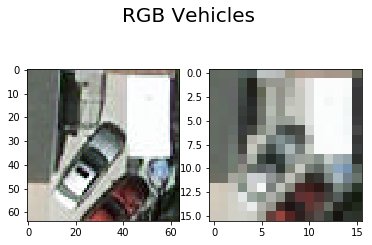

In [106]:
idx = 0

plt.figure().suptitle('RGB Vehicles', fontsize=20)
plt.subplot(1,2,1)
plt.imshow(un_normalize(im_hr[idx,:,:,:]))
plt.subplot(1,2,2)
plt.imshow(un_normalize(im_lr[idx,:,:,:]))

In [146]:
# # Prototype the Dense SR GAN
from importlib import reload
reload(DenseSRGAN_V)

<module 'DenseSRGAN_V' from '/home/jupyter/ECE285FA18_BestGroup/DenseSRGAN_Vehicles/DenseSRGAN_V.py'>

In [147]:
import DenseSRGAN_V
# gan = DenseSRGAN.DenseSRGAN(dir_pfx,im_hr,im_lr,num_gpus=4,dropout_rate=0.3,weights_path='weights/')
gan = DenseSRGAN_V.DenseSRGAN_V(dir_pfx,im_hr,im_lr,num_gpus=4,dropout_rate=0.5)

In [ ]:
#gan.dropout_rate = .5
gan.train(epochs=100,verbose=False,bench_idx=0, batch_size=1)

(1, 16, 16, 3)
Finished Epoch 0... Time: 0:05:34.803990
0:0: [D loss_hr: 0.183237, acc_hr: 0.000000, loss_gen: 0.866459, acc_gen: 0.000000]  [A loss: 9.761559, acc: 0.125000]
Epoch: 0


In [135]:
# gan = DenseSRGAN_V(dir_pfx,im_hr,im_lr,num_gpus=4,dropout_rate=0.3)

In [22]:
# Should save automatically but just in case...
gan.disc.save(dir_pfx + 'weights/discriminator_weights.h5')
gan.gen.save(dir_pfx + 'weights/generator_weights.h5')

In [ ]:
# 1117, 
ix = 1103

img = gan.gen.predict(im_lr[ix:ix+1,:,:,:]).squeeze()
img = (img + 1)/2
plt.figure().suptitle('RGB+Infra', fontsize=20)
plt.subplot(1,2,1)
plt.imshow(im_hr[ix,:,:,:])
plt.subplot(1,2,2)
plt.imshow(img)